***Sample Automated workflow for Interpolating precipitation across the range!***
Nicole Kaplan, July 30, 2020

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-packages-and-establish-working-directory" data-toc-modified-id="Import-packages-and-establish-working-directory-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import packages and establish working directory</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><span><a href="#Inverse-Distance-Weighting" data-toc-modified-id="Inverse-Distance-Weighting-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Inverse Distance Weighting</a></span></li><li><span><a href="#Classification" data-toc-modified-id="Classification-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Classification</a></span></li></ul></li><li><span><a href="#Get-Vector-Data-For-Points-and-Pastures" data-toc-modified-id="Get-Vector-Data-For-Points-and-Pastures-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Get Vector Data For Points and Pastures</a></span></li><li><span><a href="#Get-Flagged-Precipitation-Data" data-toc-modified-id="Get-Flagged-Precipitation-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Get Flagged Precipitation Data</a></span></li><li><span><a href="#Subset-and-resample-data" data-toc-modified-id="Subset-and-resample-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Subset and resample data</a></span><ul class="toc-item"><li><span><a href="#Convert-rainfall-to-inches" data-toc-modified-id="Convert-rainfall-to-inches-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Convert rainfall to inches</a></span></li><li><span><a href="#Explore-data-Frequency" data-toc-modified-id="Explore-data-Frequency-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Explore data Frequency</a></span></li></ul></li><li><span><a href="#Generate-np-Arrays-as-Input-into-IDW-Function" data-toc-modified-id="Generate-np-Arrays-as-Input-into-IDW-Function-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Generate np Arrays as Input into IDW Function</a></span></li><li><span><a href="#Run-IDW-and-Classification-Functions" data-toc-modified-id="Run-IDW-and-Classification-Functions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Run IDW and Classification Functions</a></span></li><li><span><a href="#Plot-PPT-IDW-Results" data-toc-modified-id="Plot-PPT-IDW-Results-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Plot PPT IDW Results</a></span></li></ul></div>

# Import packages and establish working directory

In [1]:
# Import Packages
import os
import math
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.spatial import cKDTree
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors
import earthpy as et
import earthpy.plot as ep

In [2]:
# Set working directory
wd_path = os.path.join(et.io.HOME, 'ea_python_spatial', 'Final_Project', 'precip-interpolator', 'data')
if not os.path.exists(wd_path):
    os.mkdir(wd_path)    
    
os.chdir(wd_path)

# Create output folder
output_path = os.path.join("output_maps")

if not os.path.exists(output_path):
    os.mkdir(output_path)  

# Functions
## Inverse Distance Weighting

In [3]:
# Class containing functions for inverse distance weighing

"""
    Inverse distance weighting (IDW)
    --------------------------------

    Compute the score of query points based on the scores of their k-nearest neighbours,
    weighted by the inverse of their distances.

    @reference:
    https://en.wikipedia.org/wiki/Inverse_distance_weighting

    Arguments:
    ----------
        X: (N, d) ndarray
            Coordinates of N sample points in a d-dimensional space.
        z: (N,) ndarray
            Corresponding scores.
        leafsize: int (default 10)
            Leafsize of KD-tree data structure;
            should be less than 20.

    Returns:
    --------
        tree instance: object
        
    Notes:
    --------
    Wrapper around ___intit____().
    
   """


class tree(object):  # use tree as the name of the function
    def __init__(self, X=None, z=None, leafsize=20):
        if not X is None:
            self.tree = cKDTree(X, leafsize=leafsize)
        if not z is None:
            self.z = np.array(z)

    def fit(self, X=None, z=None, leafsize=10):

        return self.__init__(X, z, leafsize)

    def __call__(self, X, k=6, eps=1e-6, p=2, regularize_by=1e-9):

        self.distances, self.idx = self.tree.query(X, k, eps=eps, p=p)
        self.distances += regularize_by
        weights = self.z[self.idx.ravel()].reshape(self.idx.shape)
        mw = np.sum(weights/self.distances, axis=1) / \
            np.sum(1./self.distances, axis=1)

        return mw

    def transform(self, X, k=6, p=2, eps=1e-6, regularize_by=1e-9):
        return self.__call__(X, k, eps, p, regularize_by)

## Classification

In [4]:
def classify(to_class_arr, class_list):
    """
    Function classifies numpy arrays using classes defined

    Parameters
    ----------
    to_class_arr : numpy arr
        arrays that need to be classified

    Returns
    ------
    classified_arr : numpy arr
        arrays with classified values

    """
    # Calculate classes of precipitation amount
    class_bins = class_list
    classified_arr = np.digitize(to_class_arr, class_bins)

    return classified_arr

# Get Vector Data For Points and Pastures

In [5]:
# Get shape files and pasture boundaries
pasture_path = os.path.join("input", "cper_pastures_2017_clip.shp")
pasture_org = gpd.read_file(pasture_path)
AGM_trt = pasture_org[pasture_org['Treatment'].isin(["AGM"])]

# Get shape files for site
cper_bndy_path = os.path.join("input", "CPERBody.shp")
cper_bndy = gpd.read_file(cper_bndy_path)
cper_bounds = cper_bndy.bounds

# Get locations for ppt gauges
ppt_xy_path = os.path.join("input", "ppt_locations.csv")
ppt_xy = pd.read_csv(ppt_xy_path)
ppt_xy_sort = ppt_xy.sort_values(by=['pasture'], ascending=True)

extent = (517624.84375, 527273.75, 4514740.5, 4524361.0)

# Get Flagged Precipitation Data

In [6]:
# read in abiotic data as dataframes
ppt_path = os.path.join('input', "flagged_ppt_sample.csv") 

df_ppt = pd.read_csv(ppt_path, parse_dates=['date'], delimiter = ",", usecols = (5,6,8,10,11,12))
df_ppt.rename(columns={'raw.value': 'raw_value', 'raw.measurement' : 'raw_measurement'}, inplace=True)
df_ppt['date'] = pd.to_datetime( df_ppt['date'], format='%Y-%m-%d')

# Subset and resample data 

In [8]:
# get last date in the dataset
date2 = (df_ppt['date'].max()) 
date1 = date2 - pd.offsets.Day(3)

# filter ppt data for range and resample
df_ppt_range = df_ppt.loc[(
    df_ppt['date'] > date1) & (df_ppt['date'] < date2)]
df_ppt_range = df_ppt.sort_values(by=['site'], ascending=True)

#merge dataframe and cumulative sum for each site
df_merged = pd.merge(df_ppt_range, ppt_xy[["pasture", "Easting_UTM", "Northing_UTM"]], 
                     left_on="site", right_on="pasture", how="left")
df_ppt_wks = df_merged.groupby(["site"])['raw_value'].sum()

# Get coordinates for sample location
df_xy = df_merged.groupby(["site"]).first()
df_xy = df_xy[["Easting_UTM", "Northing_UTM"]]

## Convert rainfall to inches

In [10]:
# Convert pandas column in dataframe from mm to inches
df_ppt_wks = df_ppt_wks / 25.4

## Explore data Frequency

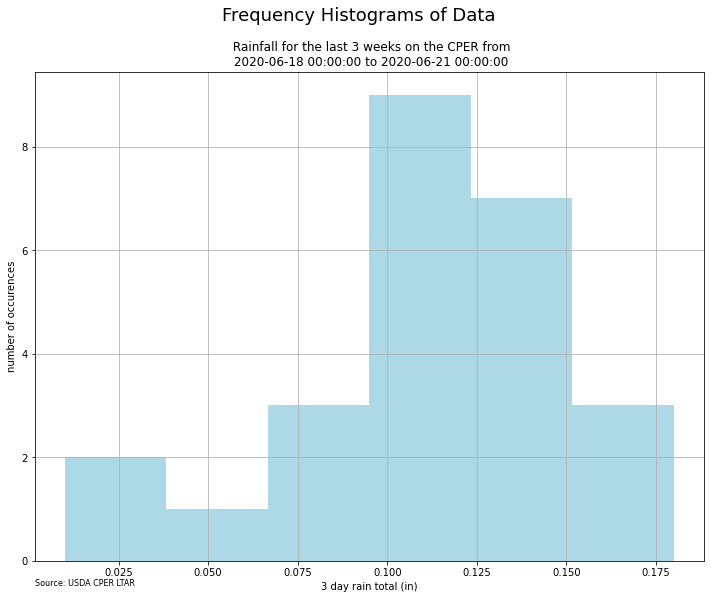

In [11]:
# Histogram of 21 day rainfall 
fig, ax1 = plt.subplots(figsize=(12,9))
fig.subplots_adjust(hspace=.6)
df_ppt_wks.hist(ax=ax1,  bins=6, color="lightblue")
ax1.set(xlabel="3 day rain total (in)",
        ylabel="number of occurences", 
        title=" Rainfall for the last 3 weeks on the CPER from\n "  +str(date1)+ " to " +str(date2))
ax1.text(0, -.05, 'Source: USDA CPER LTAR', transform=ax1.transAxes, fontsize=8)

plt.suptitle('Frequency Histograms of Data', fontsize=18)
plt.show()

# Generate np Arrays as Input into IDW Function

In [12]:
# Convert data to numpy array
ar_ppt_wks = df_ppt_wks.to_numpy()
ppt_xy_list = df_xy.to_numpy()

# Run IDW and Classification Functions

In [13]:
# Create grid from CPER boundary
spacing_x = np.linspace(517624.84375, 527273.75, 40)
spacing_y = np.linspace(4514740.5, 4524361.0, 40)
X2 = np.meshgrid(spacing_x, spacing_y)
X2 = np.reshape(X2, (2, -1)).T

In [14]:
# Assign data to be interpolated for one date
X = np.reshape(ppt_xy_list, (2, -1)).T  # site points as array

In [15]:
# Run function and return list of interpolated dataframes for tri-weekly precipitation
season_list_ppt = [-np.inf, .025, .05, .06, .07, .08, .09, .10, np.inf]

z = np.array(df_ppt_wks)  # values as array
model = tree(X, z)
model.fit()
results = model.transform(X2)


ppt_season_class = classify(results, season_list_ppt)
idw = np.column_stack((results, X2, ppt_season_class))

## Plot IDW instead of idw_df_season
idw_df_season = gpd.GeoDataFrame(idw, geometry=gpd.points_from_xy(idw[:, 1], idw[:, 2]))

# Plot PPT IDW Results

In [16]:
# Reshape array for plotting
values_ppt = [1,2,3,4,5,6,7] 
values_arr = idw[:, 3]
arr = values_arr.reshape(int(math.sqrt(values_arr.shape[0])), int(math.sqrt(values_arr.shape[0])))
arr_plt = np.flipud(arr)

In [17]:
# Create labels and colors for map
ppt_cat_names = [".025-.05", ".05-.06", ".06-.07", ".07-.08", ".08-.09", ".09-.10", ">.10"]
ppt_colors = ["white", "lightcyan", "paleturquoise", "skyblue", "lightsteelblue", "mediumslateblue", "mediumorchid"]
ppt_cmap = ListedColormap(ppt_colors)

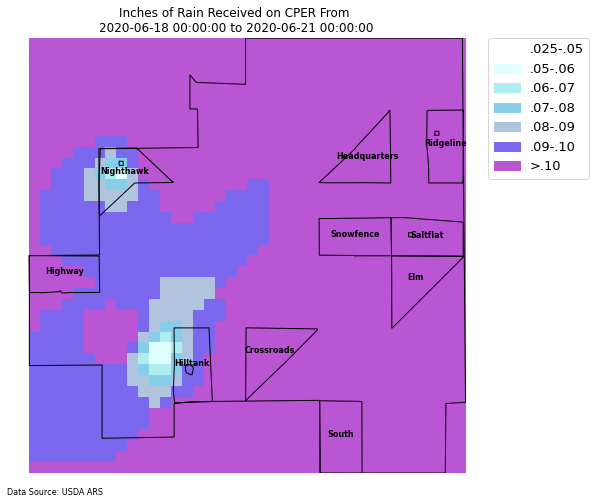

In [18]:
# Plot the data with a custom legend
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(arr_plt,
               cmap=ppt_cmap,
               vmin=1,
               vmax=7,
               extent=extent)

ep.draw_legend(im,
               classes=values_ppt,
               titles=ppt_cat_names)

cper_bndy.plot(alpha=1, ax=ax, color="none", edgecolor="black", linewidth=1)
ax2 = AGM_trt.plot(alpha=1, ax=ax, color="none", edgecolor="black", linewidth=1)
AGM_trt.apply(lambda x: ax2.annotate(s=x.CARM_Name, xy=x.geometry.centroid.coords[0], 
                                     ha='center', fontsize=8, color="black", fontweight='bold'),axis=1)

ax.set_title("Inches of Rain Received on CPER From \n" +str(date1)+ " to " +str(date2), fontsize=12)

ax.text(0, -.05, 'Data Source: USDA ARS', transform=ax.transAxes, fontsize=8)

ax.set_axis_off()

filepath = os.path.join(output_path, "interpolated_ppt.jpg")
plt.savefig(filepath, dpi=300)